## Importing Necessary Libraries

In [25]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [2]:
df = pd.read_json('news_category_dataset/News_Category_Dataset_v2.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
# WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset. Here I change the category THE WORLDPOST to WORLDPOST 
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [4]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 40 unique categories


In [5]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

In [6]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())

In [7]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['short_description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))

In [8]:
df.describe()

,categoryEncoded,descr_len,headline_len
count,200853.000000,200853.000000,200853.000000
mean,22.024366,19.728289,9.538563
std,10.753991,14.409189,3.089320
min,0.000000,0.000000,0.000000
25%,13.000000,10.000000,7.000000
50%,24.000000,19.000000,10.000000
75%,30.000000,24.000000,12.000000
max,39.000000,243.000000,44.000000


C:\Users\mz7w5s\AppData\Local\Continuum\Anaconda3\envs\py397\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


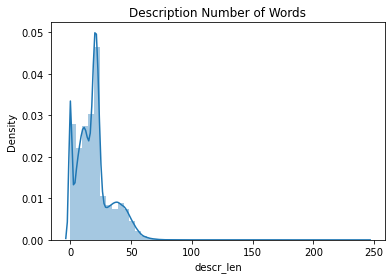

In [11]:
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

C:\Users\mz7w5s\AppData\Local\Continuum\Anaconda3\envs\py397\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


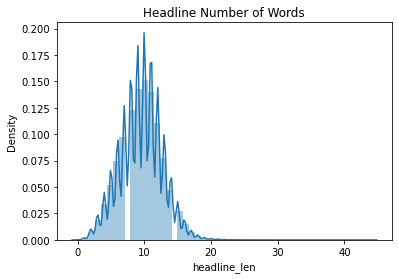

In [12]:
sns.distplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

In [13]:
df['short_description'] = df['headline'] + df['short_description']

C:\Users\mz7w5s\AppData\Local\Continuum\Anaconda3\envs\py397\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


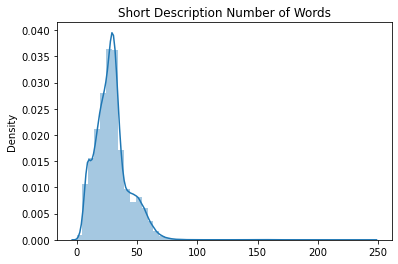

In [14]:
sns.distplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

## Tokenizing

* I use the HuggingFace tokenizer for bert to tokenize the given news descriptions. After splitting up the dataset into train and test, we encode both the training data and the testing data. 
* One more thing to notice is that we truncate the last part of the sentence when encoding it, thus adding the headlines to the front of the description means that our model will always have the headline of the news sample.

In [68]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        return_attention_mask=False,
        pad_to_max_length=True,
        max_length=maxlen,
        truncation=True
    )
    
    return np.array(enc_di['input_ids'])

In [69]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [70]:
X_train,X_test ,y_train,y_test = train_test_split(df['short_description'], df['categoryEncoded'], random_state = 2020, test_size = 0.3)

In [71]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=40,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=80)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=40,dtype = 'int32')

## Building the model

In [72]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40. 
    out = tf.keras.layers.Dense(40, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [73]:
#building the model
transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
model = build_model(transformer_layer, max_len=80)
model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 80)]             0         
                                                                 
 tf_bert_model_9 (TFBertMode  TFBaseModelOutputWithPoo  335141888
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             80, 1024),                          
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

## Training

In [74]:
#creating the training and testing dataset.
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [75]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10
   8/4393 [..............................] - ETA: 65:30:29 - loss: 3.7159 - accuracy: 0.1016

KeyboardInterrupt: 